In [1]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import json
import joblib as joblib
import pickle as pickle

In [2]:
# nltk.download('punkt')
# pip install unidecode


In [3]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')
data_val = pd.read_csv('../../Data Splits/val_data_70_30.csv')

In [4]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [5]:
# Initialize Porter Stemmer
ps = PorterStemmer()

# Load stopwords
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join(self.preprocess(text)) for text in X]
    
    def preprocess(self, text):
        tokens = nltk.word_tokenize(text)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        return filtered

In [6]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

# Define the parameter grid
param_grid = param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],  # Smoothing parameter
    'fit_prior': [True, False]  # Whether to learn class prior probabilities
}

In [7]:
# Define the steps in your pipeline
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer()),
    ('gridsearch', GridSearchCV(estimator=mnb, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1))

]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer', TfidfVectorizer()),
                ('gridsearch',
                 GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                              param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0,
                                                    2.0, 5.0, 10.0],
                                          'fit_prior': [True, False]},
                              scoring='accuracy'))])

In [8]:
best_meta = pipeline.named_steps['gridsearch'].best_estimator_
joblib.dump(pipeline.named_steps['gridsearch'].best_estimator_, '../../Models/70-30 Test/pipeline_mnb_best_estimator.joblib')


['../../Models/70-30 Test/pipeline_mnb_best_estimator.joblib']

In [9]:
print("Best Hyperparameters: ", pipeline.named_steps['gridsearch'].best_params_)
print("Best Accuracy: {:.2f}%".format(pipeline.named_steps['gridsearch'].best_score_ * 100))

Best Hyperparameters:  {'alpha': 0.1, 'fit_prior': True}
Best Accuracy: 91.01%


In [10]:

steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer()),
    ('stacking', StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta ,cv=5))
    ]
stack = Pipeline(steps)
stack.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer', TfidfVectorizer()),
                ('stacking',
                 StackingClassifier(cv=5,
                                    estimators=[('MNB', MultinomialNB()),
                                                ('LR', LogisticRegression()),
                                                ('RF',
                                                 RandomForestClassifier()),
                                                ('KNN', KNeighborsClassifier()),
                                                ('SVM', SVC(probability=True))],
                                    final_estimator=MultinomialNB(alpha=0.1)))])

Metrics for MNB:
Accuracy: 0.7450738916256158
Precision: 0.6639477977161501
Recall: 0.9975490196078431
F1 Score: 0.7972575905974535
AUC: 0.9715589205979421
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.49      0.66       404
           1       0.66      1.00      0.80       408

    accuracy                           0.75       812
   macro avg       0.83      0.74      0.73       812
weighted avg       0.83      0.75      0.73       812



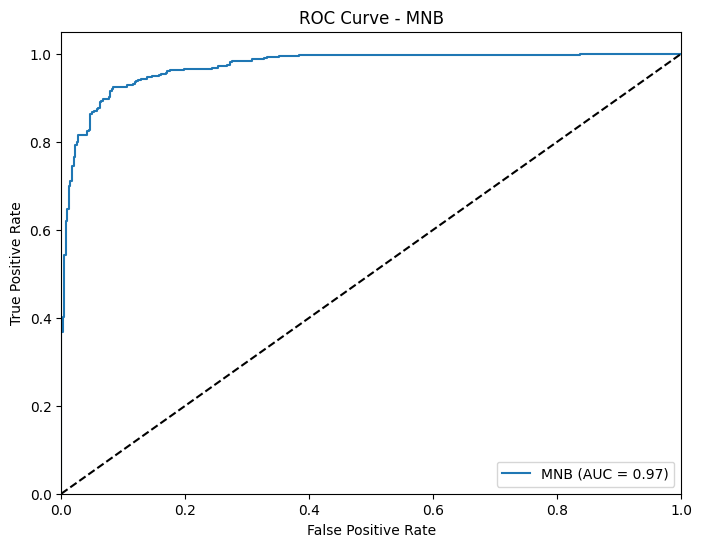

Metrics for LR:
Accuracy: 0.6231527093596059
Precision: 0.9903846153846154
Recall: 0.25245098039215685
F1 Score: 0.40234375
AUC: 0.9677247136478354
Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.72       404
           1       0.99      0.25      0.40       408

    accuracy                           0.62       812
   macro avg       0.78      0.62      0.56       812
weighted avg       0.78      0.62      0.56       812



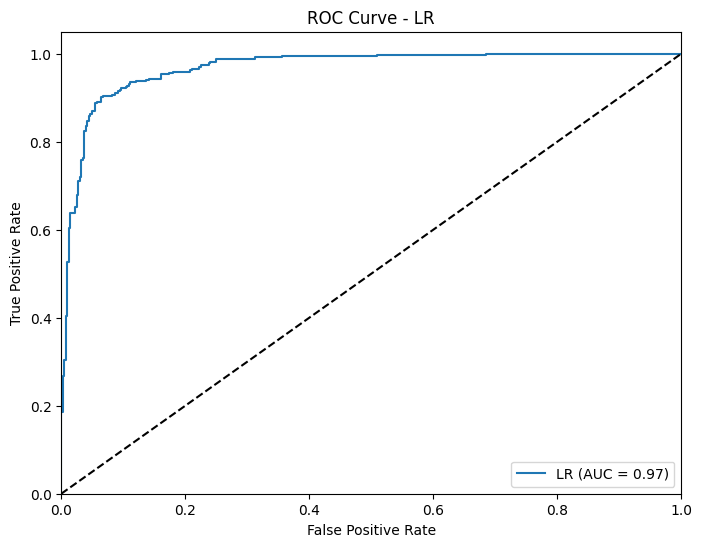

Metrics for RF:
Accuracy: 0.8793103448275862
Precision: 0.984375
Recall: 0.7720588235294118
F1 Score: 0.8653846153846154
AUC: 0.9758208357600465
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       404
           1       0.98      0.77      0.87       408

    accuracy                           0.88       812
   macro avg       0.90      0.88      0.88       812
weighted avg       0.90      0.88      0.88       812



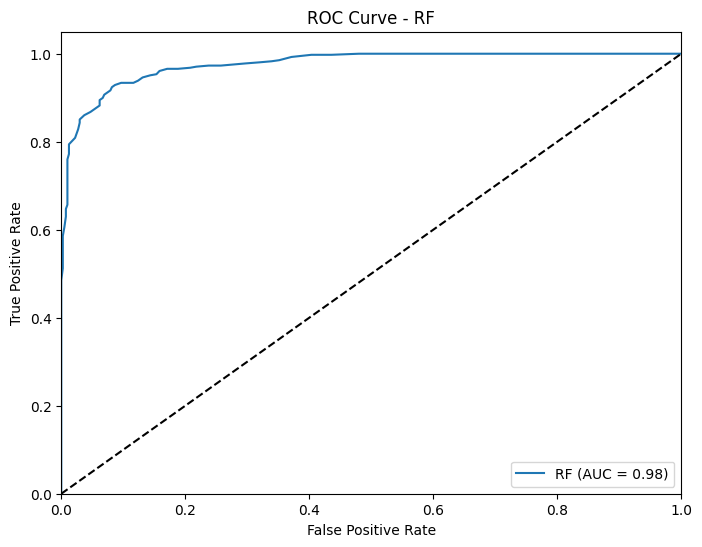

Metrics for KNN:
Accuracy: 0.7783251231527094
Precision: 0.7478260869565218
Recall: 0.8431372549019608
F1 Score: 0.7926267281105991
AUC: 0.8385447000582411
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       404
           1       0.75      0.84      0.79       408

    accuracy                           0.78       812
   macro avg       0.78      0.78      0.78       812
weighted avg       0.78      0.78      0.78       812



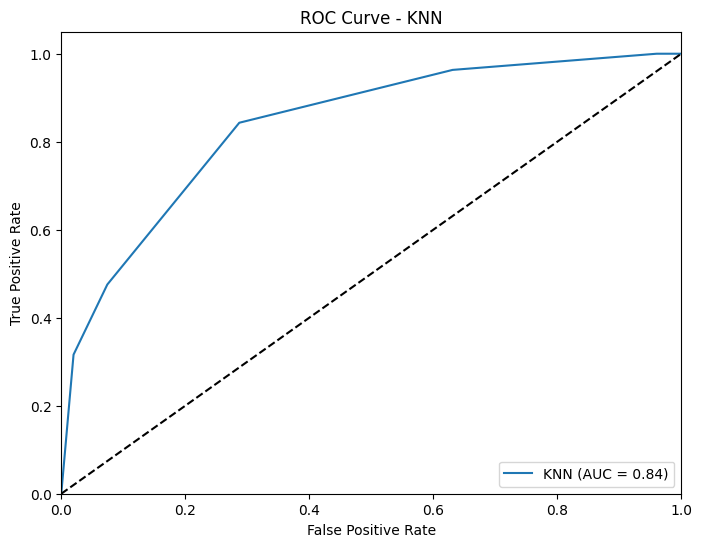

Metrics for SVM:
Accuracy: 0.5825123152709359
Precision: 1.0
Recall: 0.16911764705882354
F1 Score: 0.2893081761006289
AUC: 0.9741009027373325
Classification Report:
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       404
           1       1.00      0.17      0.29       408

    accuracy                           0.58       812
   macro avg       0.77      0.58      0.50       812
weighted avg       0.77      0.58      0.50       812



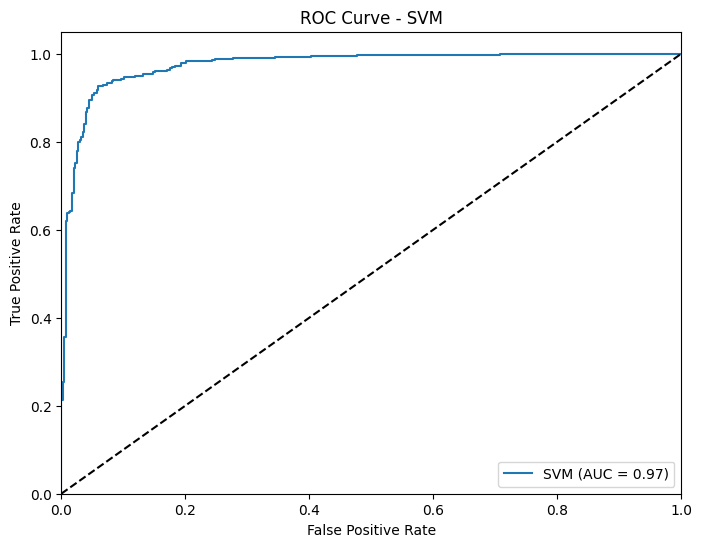

In [11]:


# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Use TFIDF inside of stacking to vectorize X_val(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_val)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9396551724137931
Precision: 0.9164733178654292
Recall: 0.9681372549019608
F1 Score: 0.9415971394517283
AUC: 0.9840868278004271
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       404
           1       0.92      0.97      0.94       408

    accuracy                           0.94       812
   macro avg       0.94      0.94      0.94       812
weighted avg       0.94      0.94      0.94       812



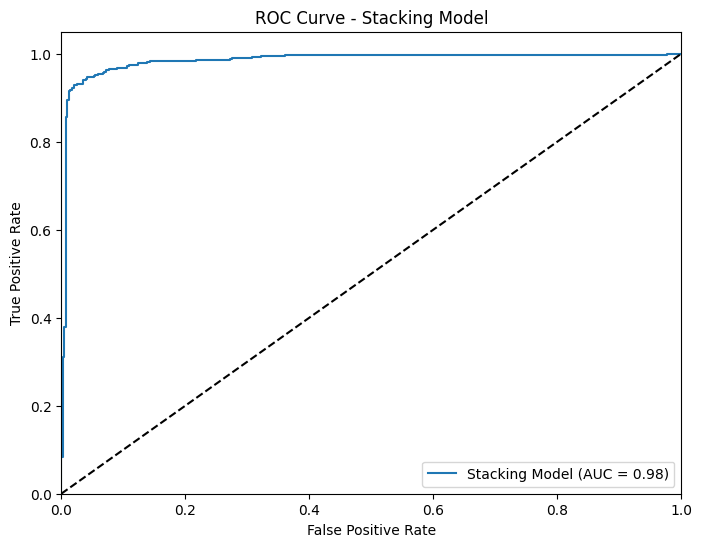

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.745074  0.663948  0.997549  0.797258  0.971559
LR              0.623153  0.990385  0.252451  0.402344  0.967725
RF               0.87931  0.984375  0.772059  0.865385  0.975821
KNN             0.778325  0.747826  0.843137  0.792627  0.838545
SVM             0.582512       1.0  0.169118  0.289308  0.974101
Stacking Model  0.939655  0.916473  0.968137  0.941597  0.984087


In [12]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val)
stack_y_prob = stack.predict_proba(X_val)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [13]:
# Save the model using joblib
joblib.dump(stack, '../../Models/70-30 Test/pipeline_mnb.joblib')

['../../Models/70-30 Test/pipeline_mnb.joblib']